In [4]:
import keras
keras.__version__

'2.2.4'

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 



## Learning word embeddings with the `Embedding` layer

The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of such a noisy, unstructured embedding space.

Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect synonyms to be embedded into similar word vectors (words meaning very different things would be embedded to points far away from each other, while related words would be closer and even beyond mere distance, we may want specific directions in the embedding space to be meaningful. 

A question that occurs is, Is there some "ideal" word embedding space that would perfectly map human language and could be used for any natural language processing task? Possibly, but in any case, we have yet to compute anything of the sort. Also, there isn't such a thing as "human language", there are many different languages and they are not isomorphic as a language is the reflection of a specific culture and a specific context.
    
    
what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to learn a new embedding space with every new task, thankfully, backpropagation makes this really easy, and Keras makes it even easier. It's just about learning the weights of a layer: the Embedding layer.

In [5]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)


**The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.**


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer or a 1D convolution layer (both will be introduced in the next sections).

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

In [62]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)


In [63]:
print('Review:',x_train[1])

print('Sentiment:',y_train[1])


Review: [1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]
Sentiment: 0


To decode the review, we need to make use of the dictionary:


In [64]:
# A dictionary mapping words to an integer index
dictionary = imdb.get_word_index()

# The first indices are reserved
dictionary = {k:(v+3) for k,v in dictionary.items()} 
dictionary["<PAD>"] = 0
# See how integer 1 appears first in the review above. 
dictionary["<START>"] = 1
dictionary["<UNK>"] = 2  # unknown
dictionary["<UNUSED>"] = 3

# reversing the vocabulary. 
# in the index, the key is an integer, 
# and the value is the corresponding word.
index = dict([(value, key) for (key, value) in dictionary.items()])

def decode_review(text):
    '''converts encoded text to human readable form.
    each integer in the text is looked up in the index, and 
    replaced by the corresponding word.
    '''
    return ' '.join([index.get(i, '?') for i in text])

In [65]:
print(decode_review(x_train[1]))

<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then


In [66]:

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [71]:
#it simply truncated the reviews to a fixed number of words (maxlen=20)  
decoded_review=decode_review(x_train[1])
print(decoded_review)
print('Length:',len(decoded_review.split()))

on the disaster that was the 80's and have a good old laugh at how bad everything was back then
Length: 20


In [72]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 130us/step - loss: 0.6759 - acc: 0.6043 - val_loss: 0.6398 - val_acc: 0.6810
Epoch 2/10
20000/20000 [==============================] - 2s 113us/step - loss: 0.5657 - acc: 0.7428 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 2s 120us/step - los

A model needs a loss function and an optimizer for training. Since this is a binary classification problem(positive or negative) and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the binary_crossentropy loss function.

This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, binary_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

We get to a validation accuracy of ~74%, which is pretty good considering that we only look at the last 20 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in 
the next few sections.

## <div style="direction:ltr;text-align:left;font-family:B Lotus, B Nazanin, Tahoma">Pre-trained word embedding </div>

Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding 
of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed 
embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The 
rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets 
in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that 
we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a 
different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or 
documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space 
for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking 
off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec 
algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one 
of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word 
Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made 
available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec 
embeddings or any other word embedding database that you can download. We will also use this example to refresh the text tokenization 
techniques we introduced a few paragraphs ago: we will start from raw text, and work our way up.

## Putting it all together: from raw text to word embeddings


We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text

</div>


<div style="direction:ltr;text-align:left;font-family:Tahoma">  

[http://ai.stanford.edu/~amaas/data/sentiment/](http://ai.stanford.edu/~amaas/data/sentiment/) or [http://dataset.class.vision/NLP/aclImdb_v1.tar.gz](http://dataset.class.vision/NLP/aclImdb_v1.tar.gz)

</div>



then it should be unpacked 




Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [81]:
import os
os.getcwd()
imdb_dir = os.getcwd()+"\\aclImdb" #is the path to the unpacked data, which contains training data and test data. 
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [82]:
texts[50]

'All the world said that the film Tashan would be a good movie with great pleasure, but this is not the case. Vijay Krishna Acharya made a serious mistake to take as an actress Kareena Kapoor. She was unbearable throughout the film. Her tom-boy look does not really goes well. Even the film the story of the film is not making sense at all. Everyone said that the Quetin Taratino of India is Vijay but its not at all Quetin. The talent Anil Kapoor was involved in this stupid movie. Anil is an actor of large caliber and this film is not. Akshay Kumar has also been a victim of this film as all is Saif. The Style and the Phoormola is not really good in this film i was disappointed'

In [84]:
labels[50] #'neg'=0 ,'pos'=1

0

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples. So we will be learning to classify movie reviews after looking at just 200 examples...


In [85]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut off reviews after 100 words
training_samples = 200  # We will be training on 200 samples to assume our data is not enough to learn a specific word embedding
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset


In [87]:

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)


In [91]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))



data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [92]:
print('Shape of training data:', x_train.shape)
print('Shape of validation data:', x_val.shape)

Shape of training data: (200, 100)
Shape of validation data: (10000, 100)


### <div style="direction:ltr;text-align:left;font-family:B Lotus, B Nazanin, Tahoma"> Download pre-trained word vectors from Glove </div>

Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens). Un-zip it.

 <p> 
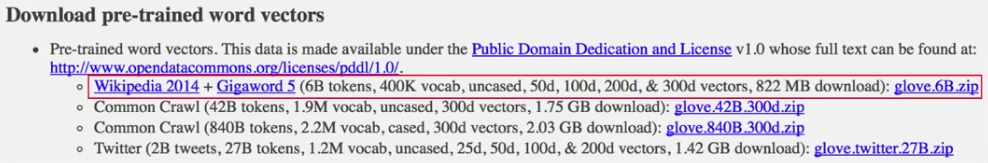 </p>

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [94]:
glove_dir = os.getcwd()+"\\aclImdb"#the path of the 100 dimensional embedding vectors downloaded from the above link

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [107]:
print('The embedding vector of the word "the": ')
print(embeddings_index['the'])
print('The length of the vector:',len(embeddings_index['the']))

The embedding vector of the word "the": 
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [109]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [113]:
embedding_matrix[2]

array([-0.071953  ,  0.23127   ,  0.023731  , -0.50638002,  0.33923   ,
        0.19589999, -0.32943001,  0.18364   , -0.18057001,  0.28963   ,
        0.20448001, -0.54960001,  0.27399001,  0.58327001,  0.20468   ,
       -0.49228001,  0.19973999, -0.070237  , -0.88049001,  0.29484999,
        0.14071   , -0.1009    ,  0.99449003,  0.36973   ,  0.44554001,
        0.28997999, -0.1376    , -0.56365001, -0.029365  , -0.4122    ,
       -0.25268999,  0.63181001, -0.44767001,  0.24363001, -0.10813   ,
        0.25163999,  0.46967   ,  0.37549999, -0.23613   , -0.14128999,
       -0.44536999, -0.65736997, -0.042421  , -0.28636   , -0.28810999,
        0.063766  ,  0.20281   , -0.53542   ,  0.41306999, -0.59722   ,
       -0.38613999,  0.19389001, -0.17809001,  1.66180003, -0.011819  ,
       -2.3736999 ,  0.058427  , -0.26980001,  1.2823    ,  0.81924999,
       -0.22322001,  0.72931999, -0.053211  ,  0.43507001,  0.85010999,
       -0.42934999,  0.92663997,  0.39050999,  1.05850005, -0.24

### Define a model

We will be using the same model architecture as before:

In [114]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [115]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [116]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 1.6337 - acc: 0.5250 - val_loss: 0.7130 - val_acc: 0.5100
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7565 - acc: 0.5800 - val_loss: 0.6910 - val_acc: 0.5418
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.5956 - acc: 0.6950 - val_loss: 1.1205 - val_acc: 0.4936
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5335 - acc: 0.7350 - val_loss: 0.7134 - val_acc: 0.5362
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4713 - acc: 0.8100 - val_loss: 0.7177 - val_acc: 0.5589
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1448 - acc: 0.9800 - val_loss: 1.3373 - val_acc: 0.4952
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2545 - acc: 0.8800 - val_loss: 1.3110 - val_acc: 0.4960
Epoch 8/10
200/200 [=======

Let's plot its performance over time:

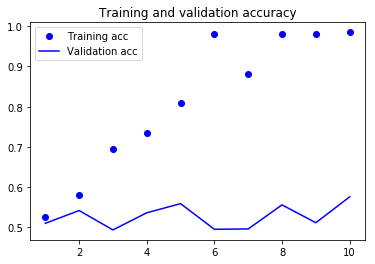

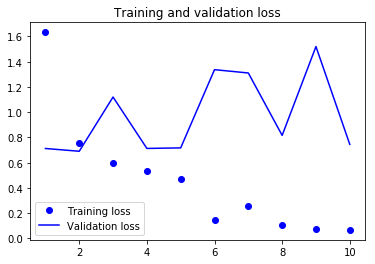

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline  
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting,which is unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [118]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 0.6951 - acc: 0.4350 - val_loss: 0.6950 - val_acc: 0.5167
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.5028 - 

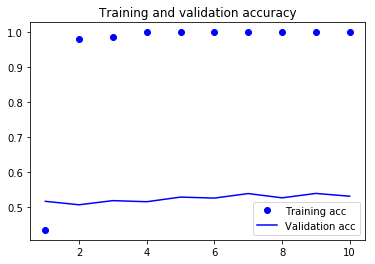

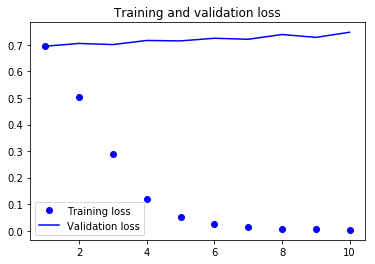

In [119]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy remains in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case 

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [120]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [29]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 57us/step


[0.7448734266090393, 0.57604]

We get an appalling test accuracy of 54%.

**As you have seen, working with only dense layers is difficult! We use Recurrent Neural Networks to get better accuracy**

### Understanding Recurrent Neural Networks

*  As you read a sentence, you don't process it in one go, instead you process it word by word, while keeping **memories** of what came befor.
  
*  Biological Intelligence processes information incrementally while maintaining **an internal state** of what it's processing, built from past information and constantly updated as new information comes in.

<p align="center">
<img src="./img/12.JPG" alt=" an internal state" />
<p align="center"> 

*  A major chracteristic of all neural networks you have seen so far, such as densely connected networks and convnets, is that they have **no memory**,each input shown to them is processed independently with **no state** kept in between inputs and to process a sequence with such networks, we have to show the entire sequence to the network at once. such networks are called **feedforward** networks 

*  A Recurrent Neural Network processes sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far.
 <p align="center">
<img src="./img/13.JPG"alt=" A Recurrent Neural Network" />
<p align="center"> 

*  The state of the RNN is reset between processing two different, independent sequences.


*  Below you will find the Numpy implementation, but in keras the complete codes are implemented in RNN layers. 
 <p align="center">
<img src="./img/14.jpg"alt=" Numpy implementation" />
<p align="center"> 